# Importing Libraries and Defining functions

### Libraries

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import spacy
from collections import Counter
from spacy import displacy
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import gensim.downloader as api
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from gensim import corpora, models
import chardet
import requests
!pip install praw
import praw
!pip install deep_translator
from deep_translator import GoogleTranslator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.8 MB/s eta 0:00:00


### Tokenization, Lemmatization, Vectorization etc.

In [2]:
#getting a model with various NLP tools such as tokenizers, lemmatizers, etc.
nlp = spacy.load("en_core_web_sm")

stop_words = nlp.Defaults.stop_words # Access the default set of stop words provided by spaCy for English
punctuations = string.punctuation # Access the set of punctuation characters from the string module
lemmatizer = WordNetLemmatizer() # Initialize the WordNet lemmatizer from NLTK
ps = PorterStemmer() # Initialize the Porter Stemmer from NLTK
snowBallStemmer = SnowballStemmer("english") # Initialize the Snowball Stemmer for English from NLTK

In [3]:
# Tokenize, lemmatize, filter stopwords/punctuations, and check if alphabetical in function
def spacy_tokenizer(sentence):

  if not sentence:  # Check if sentence is empty or None
      return []

  else:
    tokens = [
        snowBallStemmer.stem(word.lemma_.lower().strip())
        for word in nlp(sentence)
        if word.lemma_.lower().strip() not in stop_words
        and word.lemma_.lower().strip() not in punctuations
        and word.lemma_.isalpha() # alphabetic character check
    ]
    return tokens

In [4]:
wv = api.load('glove-twitter-50') #GloVe focuses on the aggregate global statistics of word co-occurrences throughout the entire text corpus to vectorize the tokens

[==================================================] 100.0% 199.5/199.5MB downloaded


In [5]:
#Evaluate the average vector for a sentence.
def sent_vec(sent, wv):

  if not sent:  # Check if sentence is empty or None
      return []

  else:
    # Extract the vectors for words found in the model's vocabulary
    word_vectors = np.array([wv[w] for w in sent if w in wv])

    if len(word_vectors) == 0:
        # If no words in the sentence are found in the model, return a zero vector
        return np.zeros(wv.vector_size)

    # Compute the average vector across all extracted word vectors
    avg_vector = np.mean(word_vectors, axis=0)

    return avg_vector

### Web Scraping Functions

In [6]:
def translator(sentence):
    translated_sentence = GoogleTranslator(source='it', target='en').translate(text=sentence)
    return translated_sentence

In [7]:
def translator_batch(sentence_list):
    translated_list = GoogleTranslator(source='it', target='en').translate_batch(sentence_list)
    return translated_list

In [8]:
#function fo extracting article text as sentences in rows of a data frame from the html code
def extract_article_data(content):

  df = pd.DataFrame(columns=["sentences"]) #initialize an empty data frame to store the setnences in the article
  sentences_list = []  # List to store extracted sentences

  for section in content: #iterate through different sections of the content

    body_paragraphs = section.find_all("p") # Find all body elements based on tag "p"
    if not body_paragraphs: continue # Handle cases where no elements are found

    for paragraph in body_paragraphs:

      paragraph_text = paragraph.get_text(separator="\n", strip=True) # handle paragraphs
      sentences = sent_tokenize(paragraph_text) # Split the paragraphs into sentences using NLTK's sentence tokenizer
      sentences_list.extend(sentences)  # Add non-Italian sentences

  df = pd.DataFrame(sentences_list, columns=["sentences"])#get the sentences into a dataframe

  return df

In [9]:
# function for extracting article text (Reuters specifically) as sentences in rows of a dataframe from html code
def extract_reuters_article_data(content, soup):
    df = pd.DataFrame(columns=['sentences']) # initializes empty dataframe to store sentences in the article
    sentences_list = [] # list to store extracted sentences

    for section in content: # iterate through different sections of content
        body_paragraphs = section.find_all('p')
        if not body_paragraphs:
            paragraph_id = section.get('data-testid') # reuters: no tag 'p', instead 'data-testid'
            body_paragraphs = soup.find('div', attrs={'data-testid': paragraph_id}) # find body paragraphs labelled 'paragraph- '

        paragraph_text = body_paragraphs.get_text(separator='\n', strip=True) # handle paragraphs
        sentences = sent_tokenize(paragraph_text) # split paragraphs into sentences using NLTK's sentence tokenizer
        sentences_list.extend(sentences) # store in list

    df = pd.DataFrame(sentences_list, columns=['sentences']) # get sentences into dataframe

    return df

In [10]:
#final scraping fuction that takes url and main body dividing class of an article
#as input and scrapes the article, transforms it into a dataframe of sentences
#and tokenizes, lemmatizes, filters stopwords/punctuations, checks if alphabetical
#and vecotorizes

def scrape(url, clss, lan = "EN"): #takes a url and class as input

  response = requests.get(url) #request and get the HTML content
  html_content = response.content

  soup = BeautifulSoup(html_content, "html.parser") #parse the HTML content

  content = soup.find_all("div", class_= clss) #get the content of the main text
  data = extract_article_data(content) #extract the sentences into a data frame

  if lan == "IT":
    data["sentences"] = data["sentences"].apply(lambda sentence: translator(sentence)) #tanslate sentences into english if indicated that they are in italian

  data["tokens"] = data["sentences"].apply(lambda sentence: spacy_tokenizer(sentence)) #apply the tokenizer function
  data['joined tokens'] = data['tokens'].apply(lambda x: ' '.join(x)) #join the tokenized sentences back together for analysis
  data['vector'] = data['sentences'].apply(lambda x: sent_vec(x, wv)) #apply vectorization

  return data

In [11]:
# using selenium to obtain html content
def scrape_dynamic(url, clss):

    driver = webdriver.Firefox() # start web browser: Chrome (or use Firefox, )
    driver.get(url) # request url
    html_content = driver.page_source # get html content
    driver.close() # close web browser

    soup = BeautifulSoup(html_content, 'html.parser') # parse html content
    content = soup.find_all('div', class_=clss) # get content of main text
    data = extract_reuters_article_data(content, soup) # extract sentences into dataframe

    data['tokens'] = data['sentences'].apply(lambda sentences: spacy_tokenizer(sentences)) # apply tokenizer function
    data['vector'] = data['sentences'].apply(lambda x: sent_vec(x, wv)) # apply vectorization

    return data

### Reddit Scraping Functions

In [12]:
# create instance of reddit class (read-only)
# client_id, client_secret, and user_agent are associated with the test app from claire's account
reddit = praw.Reddit(client_id = 'OuQ4O6csiU6qPjs3icSLLw',
                    client_secret = 'waYHFVjeqtafXuFupji5150fceJs3A',
                    user_agent = 'test by u/clairexxxooo')

# return None: read-only mode
print(reddit.user.me())

None


In [13]:
def scrape_reddit(url):
    submission = reddit.submission(url=url) # submission object

    #en_comments = []
    it_comments = []
    for top_comments in submission.comments:
        it_comments.append(top_comments.body)
        for second_comments in top_comments.replies:
            it_comments.append(second_comments.body)

    #for top_comments in submission.comments:
        #en_comments.append(translator(top_comments.body))
        #for second_comments in top_comments.replies:
            #en_comments.append(translator(second_comments.body))

    en_comments = translator_batch(it_comments)

    en_comments = [comment for comment in en_comments if comment] # remove empty comments

    #data = extract_reddit_data(en_comments)
    data = extract_reddit_data(en_comments)
    data['tokens'] = data['sentences'].apply(lambda sentences: spacy_tokenizer(sentences))
    data['vector'] = data['sentences'].apply(lambda x: sent_vec(x, wv))

    return data

In [14]:
# function to extract reddit comments (first level and second level comments) separate sentences
# into a dataframe
def extract_reddit_data(content):

    df = pd.DataFrame(columns=['sentences']) # initializes empty dataframe to store sentences in the article
    sentences_list = [] # list to store extracted sentences
    for section in content: # iterate through different sections of content
        paragraph_text = section.strip() # handle paragraphs
        sentences = sent_tokenize(paragraph_text) # split paragraphs into sentences using NLTK's sentence tokenizer
        sentences_list.extend(sentences) # store in list

    df = pd.DataFrame(sentences_list, columns=['sentences']) # get sentences into dataframe

    return df

### NLP Task Functions

In [32]:
# function for keyword extraction

def keyword_extract(article_dict):

  keywords = {}  # a dictionary to hold teh urls and corresponding top 5 features

  for url, data in article_dict.items():

    vectorizer = TfidfVectorizer(max_features=5)  # Extract top 5 keywords
    data['document'] = data['tokens'].apply(lambda x: ' '.join(x)) #take the tokenized list and join it back into a document

    # Check for empty document
    if not data['document'].empty:

      X = vectorizer.fit_transform(data['document'])  #Fits the TF-IDF vectorizer to learn the importance of the words
      feature_names = vectorizer.get_feature_names_out()  # Get the vocabulary
      top_keywords = feature_names[X.sum(axis=0).argsort()[-5:]]  #Sums the TF-IDF scores across all documents, sorts the summed scores in descending order and retrieves the last 5 (most important)
      keywords[url] = top_keywords  # Add keywords to the dictionary

    else:
      print(f"Warning: Document for URL '{url}' is empty. Skipping keyword extraction.")
      continue

  return keywords  # Return the keywords dictionary

In [46]:
#take articles in a dictionary and return the most frequent keywords
def frequent_keywords (article_dict):

  world_keywords = keyword_extract(article_dict) #extract the keywords for each article using the prior function

  all_keywords = [] #start a list to store all keywords
  for url, keywords in world_keywords.items(): #add keywords to the list
    for keywords in keywords:
      all_keywords.extend(keywords)

  keyword_counts = Counter(all_keywords) #apply a counter to count the frequency of the keywords in the list

  top_keywords = keyword_counts.most_common(10) #extract the 10 most common keywords

  #print the keywords
  print("Top Keywords:")
  for keyword, count in top_keywords:
    print(f"Keyword: {keyword} ; Count: {count}")

In [17]:
# function for creating a wordcloud
def wordcloud(article_dict):

    all_articles_text = "" #initialize an empty string for the text of all the articles

    for url, article_df in article_dict.items(): #loop through the data frames

      for sentence_tokens in article_df['tokens'].tolist(): #loop through the word tokens colun

        joined_sentence = " ".join(sentence_tokens) # Join the word tokens within each sentence into a string
        all_articles_text += joined_sentence + " "  # Concatenate the joined sentence to the all_articles_text string

    wordcloud = WordCloud(background_color="white", width=800, height=600).generate(all_articles_text) # Create the word cloud object

    # Create a figure and display the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Chiara Ferragni Scandal Word Cloud")
    plt.show()

In [18]:
# simple sentiment analysis
def sentiment (article_dict):

  average_sentiment_dict = {} #dictionary for holding the average sentiment per article
  sentiment_dict ={} #dicitonary fpor holding the individual sentence sentiments per article

  for url, data in article_dict.items(): #iterate all articles dataframes

    sentiment_scores_list = [] #list for holding the sentiment scores of the sentences

    for sentence in data['joined tokens']: #iterate the joined sentences of each dataframe
      sentiment_scores_list.append(TextBlob(sentence).sentiment)  # Analyze sentiment for each sentence and append it to the list of scores

    data['sentiment'] = sentiment_scores_list # Add sentiment scores as a new column to the DataFram

    sentiment_classes = [] #a list to hold the sentiment classes neutral, positive and negative
    for score in sentiment_scores_list: #if statement to assign a class based on the sentiment score of each sentence
      if score.polarity < -0.2: sentiment_classes.append("Negative")
      elif score.polarity > 0.2: sentiment_classes.append("Positive")
      else: sentiment_classes.append("Neutral")

    data['sentiment_class'] = sentiment_classes  # Add sentiment class labels

    sentiment_dict[url] = data #add the data frame to the dictionary

    if len(sentiment_scores_list) > 0: #avoid divison by zero
      average_polarity = sum(score.polarity for score in sentiment_scores_list) / len(sentiment_scores_list) # Calculate summary sentiment
    else:
      continue

    if average_polarity < -0.2: average_sentiment_dict[url] = "Negative" #add a class assigned based on average polarity of the articles into a doctionary with the url of the article as the key
    elif average_polarity > 0.2: average_sentiment_dict[url] = "Positive"
    else: average_sentiment_dict[url] = "Neutral"

  return sentiment_dict, average_sentiment_dict #return both dictionaries

In [19]:
#more complex sentiment analysis

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

def comp_sentiment (article_dict):

  sentiment_dict ={} #dicitonary fpor holding the individual sentence sentiments per article

  for url, data in article_dict.items(): #iterate all articles dataframes

    joined_tokens = data['tokens'].apply(lambda x: ' '.join(x)) #join the tokenized sentences back together for analysis
    sentiment_scores_list = [] #list for holding the sentiment scores of the sentences

    for sentence in joined_tokens: #iterate the joined sentences of each dataframe
      sentiment = classifier(sentence)
      sentiment_scores_list.append(sentiment[0][0])  # Analyze sentiment for each sentence and append the highest scored to the list of scores

    data['complex sentiment'] = sentiment_scores_list # Add sentiment scores as a new column to the DataFram
    sentiment_dict[url] = data #add the data frame to the dictionary

  return sentiment_dict  #return dictionary

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [20]:
# Topic modeling
# Function to perform topic modeling on a dictionary of articles

def topic_modeling(article_dict):
  # Combine all articles into a single list of sentences
  sentences = []
  for url, article in article_dict.items():
      sentences.extend(article['tokens'])

  # Create a dictionary from the combined sentences
  dictionary = corpora.Dictionary(sentences)

  # Create a corpus from the combined sentences and dictionary
  corpus = [dictionary.doc2bow(doc) for doc in sentences]

  # Train the topic model
  lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=1, passes=10, iterations=200)

  return dictionary, lda_model

In [21]:
# Entity recongnition function


In [22]:
def relationships(article_dict):

  nlp = spacy.load("en_core_web_sm")  # Load spaCy English model (smaller)

  for url, article in article_dict.items(): # Iterate through each article (URL, DataFrame) in the dictionary
    relationships = []  # List to store relationships for each sentence

    # Iterate through each sentence in the article
    for joined_tokens in article["joined tokens"]:
      rel = nlp(joined_tokens) #apply spacy model to each sentence in the data frame
      sentence_relationships = []

      important_entity = ["PERSON", "ORG", "GPE", "LOC", "PRODUCT", "FAC",
                          "WORK_OF_ART", "DATE","TIME", "MONEY", "PERCENT",
                          "EVENT", "NORP", "FACILITY", "LAW", "LANGUAGE","QUANTITY",
                          "ORDINAL", "CARDINAL", "MISC"] #list of important named entity types
      important_dependency = ["subj", "obj", "nmod", "poss", "appos", "xcomp",
                              "conj", "cc", "aux", "advcl",
                              "prep", "pobj", "det", "prt"] #list of relevant dependency labels

      # Identify named entities and their relationships based on dependency parsing
      for token in rel: #iterates over each individual token (word) in the processed sentence
        if token.ent_type_: #checks if the current token (word) is a named entity

          for child in token.children:  # iterates through its children if token is a named entity
            if child.ent_type_:  # Check if child is also an entity to try to discover a relationship between them
              # Filter based on both NEType and dependency label
              sentence_relationships.append({
                "entity1": token.text,
                "entity2": child.text,
                "dependency_relation": child.dep_,
              })# if both the current token and its child are confirmed to be named entities, this part creates a dictionary containing information about the relationship and appends it to a list called sentence_relationships

              if (token.ent_type_ in important_entity and child.ent_type_ in important_entity and child.dep_ in important_dependency): #test if entities are interesting types and dependicies are interetesing labels
                print(url)
                displacy.render(rel, style="dep")  # Render dependency parse with relationships highlighted

      relationships.append(sentence_relationships) #If both the current token and its child are confirmed to be named entities, this part creates a dictionary containing information about the relationship

    article["relationships"] = relationships # Add 'relationships' column to the DataFrame

  return article_dict #returns the dictionary

In [23]:
# Text summarization using similarity scores and selection of the GloVe vector word embedding

def summarize_article(article_dict, summary_length=5):

  #Loop through the dictionary for my
  for url, article in article_dict.items():
    scores = [] # Create an empty list to store sentence scores for the current article
    document_vector = np.mean(article["vector"], axis=0) # Calculate the document vector

    # Loop through each sentence vector in the article
    for sentence_vector in article["vector"]:
      similarity_score = np.dot(document_vector, sentence_vector) / (np.linalg.norm(document_vector) * np.linalg.norm(sentence_vector)) # Calculate cosine similarity score between the document vector and the current sentence vector
      scores.append(similarity_score) # Append the calculated similarity score to the scores list

    article['score'] = scores # Add the 'score' column to the article DataFrame, containing the calculated similarity scores for each sentence

    summary_sentences = article.sort_values(by='score', ascending=False).head(summary_length) # Sort the article DataFrame by the 'score' column in descending order and select top sentences by score
    summary_text = '\n'.join(summary_sentences['sentences'].tolist())

    print(url)
    print(summary_text)


# News Article Implementation

### Scrape Articles

In [24]:
# EU articles: 16
EU_articles = {"https://www.bbc.co.uk/news/world-europe-67759633" : "ssrcss-7uxr49-RichTextContainer e5tfeyi1", #bbc
            "https://www.telegraph.co.uk/world-news/2023/12/19/italy-influencer-chiara-ferragni-fined-christmas-cake-sale/":"articleBodyText section", #telegraph
            "https://www.theguardian.com/world/2024/jan/13/chiara-ferragni-italy-influencers-charity-christmas-cake-scandal":"dcr-ch7w1w", #theguardian
            "https://www.independent.co.uk/life-style/chiara-ferragni-pandoro-charity-fined-b2467495.html" : "sc-1fcmxs3-1 sc-1i4xxi7-1 gypkPg jdNiRn", #independent
            "https://www.independent.co.uk/news/world/europe/chiara-ferragni-ap-italian-rome-italy-b2475218.html" : "sc-jbiisr-0 dJaXMd sc-jbiisr-2 dbwULn", #independent
            "https://www.independent.co.uk/news/world/europe/italian-ap-chiara-ferragni-cabinet-rome-b2485042.html" :"sc-jbiisr-0 dJaXMd sc-jbiisr-2 dbwULn", #independent
            "https://www.hellomagazine.com/hfm/culture/510008/chiara-ferragni-pandoro-panettone-scandal/" : "articleBody_a12v6gcb HFMBodyContent_hs8dd92", #hellomagazine
            "https://www.euronews.com/business/2023/12/22/chiara-ferragni-how-influential-are-influencers-on-consumer-decisions": "c-article-content c-article-content--business js-article-content", #euronews
            "https://www.swissinfo.ch/eng/italy-s-meloni-takes-aim-at-influencer-ferragni-over-misleading-claims/49066542" : "content-container", #swissinfo
            "https://www.swissinfo.ch/eng/italy-regulator-tightens-rules-on-influencers-after-ferragni-scandal/71249603" : "content-container", #swissinfo
            "https://www.swissinfo.ch/eng/italy-tightens-charity-giving-rules-after-influencer-ferragni-scandal/71867382" : "content-container", #swissinfo
            'https://tiranapost.al/english/stil-jete/chiara-ferragni-kerkon-falje-do-i-dhuroj-spitalit-nje-milion-euro-i529927': 'c-open-content', #tiranapost (albania)
            'https://www.just-food.com/news/italys-balocco-under-antitrust-probe-over-misleading-marketing-campaign/': 'cell large-8 main-content', #just-food (uk)
            'https://english.elpais.com/people/2024-02-12/the-storm-around-chiara-ferragni-is-not-letting-up.html': 'a_c clearfix', # el pais
            'https://english.elpais.com/people/2023-12-27/chiara-ferragnis-empire-is-on-thin-ice-due-to-a-fake-charity-campaign.html#': 'a_c clearfix', # el pais
            'https://efa-net.eu/news/italian-influencer-fundraising-scandal-must-lead-to-better-standards-says-assif': 'the_content_wrapper', # european fundraising association, netherlands
            }
EU_scraped_data = {} #dictionary for storing different datasets  with urls associated as keys

for url, clss in EU_articles.items(): #iterate through the articles
  data = scrape(url, clss) #scrape the articles one after another
  EU_scraped_data[url] = data

In [25]:
# Italian articles in english: 15
IT_articles_en = {'https://www.ilmessaggero.it/en/chiara_ferragni_and_the_ferragni_balocco_case_jurisdiction_decision-7902021.html': 'body-text', # il messaggero
                   'https://milano.corriere.it/notizie/cronaca/24_febbraio_24/chiara-ferragni-i-am-far-from-perfect-but-i-ve-always-been-in-good-faith-fedez-it-s-right-to-keep-our-problems-to-ourselves-64ed411d-0605-4b97-9382-fc11ee5a2xlk.shtml': 'content', # corriere milano
                   'https://www.unionesarda.it/en/the-balocco-ferragni-pandoro-and-the-quot-incorrect-charity-practicesquot-the-accusation-by-the-antitrust-bzabcl5h': 'article-body article-share', #unione sarda
                   'https://www.unionesarda.it/en/italy/chiara-ferragni-and-balocco-huge-fine-from-the-antitrust-14-million-fine-for-the-designer-pandoro-rft9jc2z': 'article-body article-share', #unione sarda
                   'https://www.wantedinrome.com/news/italy-chiara-ferragni-influencer-pandoro.html': 'tdb-block-inner td-fix-index', # wanted in rome
                   'https://www.ansa.it/english/news/business/2023/12/18/ferragni-to-donate-1-mn-to-hospital-amid-pandoro-furore_410f0b3e-f074-4bf0-ac55-782c9965bde4.html': 'article-main', # ansa
                   'https://www.ansa.it/english/news/general_news/2023/12/21/finance-cops-to-get-antitrust-docs-in-ferragni-pandoro-case_1395ffa2-f2ea-4caf-900a-c0e845cffea9.html': 'article-main', #ansa
                   'https://www.ansa.it/english/news/business/2023/12/19/ferragni-in-new-storm-over-easter-egg-after-pandoro-row_0454608b-5700-4fef-b477-3e9b659a9d40.html': 'article-main', # ansa
                   'https://www.ansa.it/english/news/2023/12/15/ferragni-to-challenge-unjust-antitrust-decision-on-pandoro_d7cc3207-b3b5-46fa-8ae6-15684c74d744.html': 'article-main', # ansa
                   'https://www.ansa.it/english/news/lifestyle/arts/2024/02/14/ferragni-appeals-against-antitrust-fine_cf3b098f-9b3a-490d-b846-fb0c5897789a.html': 'article-main', # ansa
                   'https://www.ansa.it/english/news/2024/01/08/ferragni-balocco-case-could-become-fraud-probe_17cd4768-32bc-4846-9995-82eb0de8e846.html': 'article-main', # ansa
                   'https://www.ansa.it/english/news/2024/01/05/coca-cola-says-for-now-ferragni-content-will-not-be-used_820a76dc-4a56-4989-b820-20d7e93a9614.html': 'article-main', # ansa
                   'https://www.ansa.it/english/news/business/2023/12/15/antitrust-fines-ferragni-and-balocco-over-pandoro-sales_fbb9189f-bee2-49cd-82d1-704cb7a0a0e0.html': 'article-main', # ansa
                   'https://www.aboutresilience.com/what-i-honestly-think-about-you/': 'td-ss-main-content', # about resilience
                   'https://www.firstonline.info/en/chiara-ferragni-su-instagram-chiede-scusa-per-il-pandoro-balocco-bufera-anche-sulle-uova-di-pasqua/': 'entry-content' # first online
                   }
IT_en_scraped_data = {}

for url, clss in IT_articles_en.items(): #iterate through the articles
  data = scrape(url, clss) #scrape the articles one after another
  IT_en_scraped_data[url] = data

In [28]:
IT_articles_it = {'https://www.gamberorosso.it/notizie/caso-balocco-ferragnez/': 'ct-inner-content', # gambero rosso
                   'https://www.fanpage.it/spettacolo/personaggi/caso-chiara-ferragni-e-balocco-cosa-e-successo-dal-pandoro-griffato-al-video-di-scuse-dellinfluencer/': 'fp_single-article__col-sx', # fanpage
                   'https://www.gazzetta.it/spettacolo/14-02-2024/caso-balocco-chiara-ferragni-impugna-la-multa-dell-antitrust.shtml': 'column gz-content-center-col main-content-center is-6', # gazzetta
                   'https://www.rainews.it/articoli/2024/01/ferragni-truffa-indagata-balocco-pandoro-gdf-beneficenza-b02b1f84-48d8-48ec-9af5-d3d0140a2e66.html': 'article__content', # rai
                   'https://www.ansa.it/sito/notizie/cronaca/2024/01/08/caso-balocco-chiara-ferragni-indagata-per-truffa-_607f71c5-c2e5-4553-bf25-f1f9b3e29dcd.html': 'article-main', # ansa
                   'https://www.repubblica.it/cronaca/2024/01/14/news/ferragni_pandoro_risposta_balocco_a_codacons-421874981/': 'story__text', # repubblica
                   'https://www.ilsole24ore.com/art/ferragni-balocco-impugna-provvedimento-agcm-corte-conti-inchiesta-selfie-sanremo-AFJmxCiC': 'col-lg-10', # il sole 24 ore
                   'https://milano.corriere.it/notizie/cronaca/24_gennaio_30/chiara-ferragni-e-il-caso-del-pandoro-balocco-ha-rafforzato-la-sua-immagine-con-le-campagne-di-beneficenza-349446ac-e944-4a06-98f4-e6da7a74axlk.shtml': 'column is-8', # corriere milano
                   'https://www.vanityfair.it/article/chiara-ferragni-indagata-truffa-aggravata-caso-pandoro-balocco': 'body__inner-container', # vanity fair italy
                   'https://tg24.sky.it/cronaca/2024/02/21/chiara-ferragni-pandoro-balocco-oreo': 'c-article-section j-article-section l-spacing-m o-content-at-the-bottom-mt', # sky tg24
                   'https://www.milanotoday.it/cronaca/ferragni-pandoro-truffa.html': 'c-entry', # milano today
                   'https://www.ilfoglio.it/economia/2024/02/28/news/chiara-e-ingannevole-6269002/': 'desc body-content', # il foglio
                   }
IT_it_scraped_data = {}

for url, clss in IT_articles_it.items(): #iterate through the articles
  data = scrape(url, clss, lan = "IT") #scrape the articles one after another
  IT_it_scraped_data[url] = data

In [26]:
# US Data: 10
US_articles = {'https://www.forbes.com/sites/annazanardicappon/2024/03/11/hypocrisy-the-plague-of-social-relations/?sh=2be2ff1c452b': 'body-container', # forbes
              'https://apnews.com/article/italy-pandoro-pink-cake-ferragni-influencer-c9ecc9c2cb9edf4a2eccda224892cb80': 'Page-content', # associated press
              'https://apnews.com/article/italy-influencer-ferragni-e14294868f780c273a58edd28e6ca773':'Page-content', # associated press
              'https://apnews.com/article/chiara-ferragni-italy-influencer-blogger-132660e49e4a96185c34d0b0f7de2e12':'Page-content', # associated press
              'https://apnews.com/article/italy-fashion-businesswoman-influencer-antitrust-charity-764fe42ff5a4a1ec9f553c5b63538578':'Page-content', # associated press
              'https://www.businessinsider.com/inside-rise-chiara-ferragni-italian-social-media-influencer-cakes-fine-2023-12?r=US&IR=T': 'content-lock-content', # business insider
              'https://www.businessinsider.com/chiara-ferragni-influencer-investigated-fraud-over-misleading-charity-cake-2024-1?r=US&IR=T:':'content-lock-content', # business insider
              'https://www.businessinsider.com/influencer-fined-1-million-over-misleading-charity-cake-campaign-2023-12?r=US&IR=T': 'content-lock-content', # business insider
              'https://lavocedinewyork.com/en/news/2024/01/05/coca-cola-dumps-mega-influencer-chiara-ferragni-after-pandoro-scandal/': 'content-inner', #la voce di new york
              'https://lavocedinewyork.com/en/news/2024/01/09/chiara-ferragni-probe-into-pandoro-gate-escalates-to-aggravated-fraud/': 'content-inner', # la voce di new york
              }
US_scraped_data = {}

for url, clss in US_articles.items():
    data = scrape(url, clss)
    US_scraped_data[url] = data

In [27]:
# world news articles: 5
world_articles = {'https://au.news.yahoo.com/chiara-ferragni-apologises-misleading-fans-131900054.html': 'caas-body', # australia yahoo
                 'https://www.mamamia.com.au/what-did-chiara-ferragni-do/':'post-content defaultClass', # australia
                 'https://www.newshub.co.nz/home/lifestyle/2023/12/italian-fashion-influencer-chiara-ferragni-fined-nearly-2-million-for-misleading-christmas-cake-ad.html': 'c-ArticleBody', # new zealand
                 'https://sg.news.yahoo.com/safilo-group-interrupts-chiara-ferragni-193422977.html':'caas-body', # singapore
                 'https://newseu.cgtn.com/news/2024-02-25/Influencer-s-Christmas-cake-took-the-biscuit-say-Italian-regulators-1ruccrtNoJi/p.html': 'm-content' # cgtn china
                 }

world_scraped_data = {}

for url, clss in world_articles.items():
    data = scrape(url, clss)
    world_scraped_data[url] = data

In [ ]:
# EU articles (reuters): 5 - must use the scrape_dynamic function, does not work in google colab
reuters_articles = {"https://www.reuters.com/lifestyle/top-influencer-ferragni-fined-12-mln-christmas-cake-advertising-case-2023-12-15/": 'text__text__1FZLe text__dark-grey__3Ml43 text__regular__2N1Xr text__small__1kGq2 body__full_width__ekUdw body__small_body__2vQyf article-body__paragraph__2-BtD',
                  'https://www.reuters.com/world/europe/italy-regulator-tightens-rules-influencers-after-ferragni-scandal-2024-01-11/': 'text__text__1FZLe text__dark-grey__3Ml43 text__regular__2N1Xr text__small__1kGq2 body__full_width__ekUdw body__small_body__2vQyf article-body__paragraph__2-BtD',
                  'https://www.reuters.com/world/europe/italys-meloni-takes-aim-influencer-ferragni-over-misleading-claims-2023-12-17/': 'text__text__1FZLe text__dark-grey__3Ml43 text__regular__2N1Xr text__small__1kGq2 body__full_width__ekUdw body__small_body__2vQyf article-body__paragraph__2-BtD',
                  'https://www.reuters.com/lifestyle/italian-influencer-ferragni-apologises-over-misleading-charity-claims-2023-12-18/': 'text__text__1FZLe text__dark-grey__3Ml43 text__regular__2N1Xr text__small__1kGq2 body__full_width__ekUdw body__small_body__2vQyf article-body__paragraph__2-BtD',
                  'https://www.reuters.com/business/retail-consumer/italian-influencer-ferragnis-woes-continue-eyewear-maker-safilo-pulls-contract-2023-12-21/': 'text__text__1FZLe text__dark-grey__3Ml43 text__regular__2N1Xr text__small__1kGq2 body__full_width__ekUdw body__small_body__2vQyf article-body__paragraph__2-BtD'
                   }
#reuters_class = "text__text__1FZLe text__dark-grey__3Ml43 text__regular__2N1Xr text__small__1kGq2 body__full_width__ekUdw body__small_body__2vQyf article-body__paragraph__2-BtD"

EU_reuters_scraped_data = {} #dictionary for storing different datasets  with urls associated as keys

for url, clss in reuters_articles.items(): #iterate through the articles
  data = scrape_dynamic(url, clss) #scrape the articles one after another
  EU_reuters_scraped_data[url] = data

# EU_reuters_scraped_data

In [29]:
#create a dictionary for all articles in the world
world = EU_scraped_data.copy()
for d in [IT_en_scraped_data, US_scraped_data, world_scraped_data, IT_it_scraped_data]:
  world.update(d)

### NLP Application

In [33]:
#keyword extraction
keywords = keyword_extract(EU_scraped_data)

print(f"Top keywords for each article:")
for url, keywords in keywords.items():
  print(f"URL: {url}")
  print(f"Top Keywords: {keywords}")

Top keywords for each article:
URL: https://www.bbc.co.uk/news/world-europe-67759633
Top Keywords: [['ms' 'pandoro' 'hospit' 'ferragni' 'cake']]
URL: https://www.telegraph.co.uk/world-news/2023/12/19/italy-influencer-chiara-ferragni-fined-christmas-cake-sale/
Top Keywords: [['christma' 'donat' 'cake' 'promot' 'ferragni']]
URL: https://www.theguardian.com/world/2024/jan/13/chiara-ferragni-italy-influencers-charity-christmas-cake-scandal
Top Keywords: [['investig' 'itali' 'follow' 'influenc' 'ferragni']]
URL: https://www.independent.co.uk/life-style/chiara-ferragni-pandoro-charity-fined-b2467495.html
Top Keywords: [['agenc' 'brand' 'fine' 'euro' 'ferragni']]
URL: https://www.independent.co.uk/news/world/europe/chiara-ferragni-ap-italian-rome-italy-b2475218.html
Top Keywords: [['cake' 'agenc' 'euro' 'balocco' 'ferragni']]
URL: https://www.independent.co.uk/news/world/europe/italian-ap-chiara-ferragni-cabinet-rome-b2485042.html
Top Keywords: [['euro' 'italian' 'chariti' 'cake' 'ferragni']]

In [47]:
frequent_keywords(world)

Top Keywords:
Keyword: ferragni ; Count: 51
Keyword: euro ; Count: 29
Keyword: balocco ; Count: 17
Keyword: compani ; Count: 16
Keyword: million ; Count: 13
Keyword: pandoro ; Count: 12
Keyword: donat ; Count: 11
Keyword: cake ; Count: 10
Keyword: italian ; Count: 10
Keyword: influenc ; Count: 9


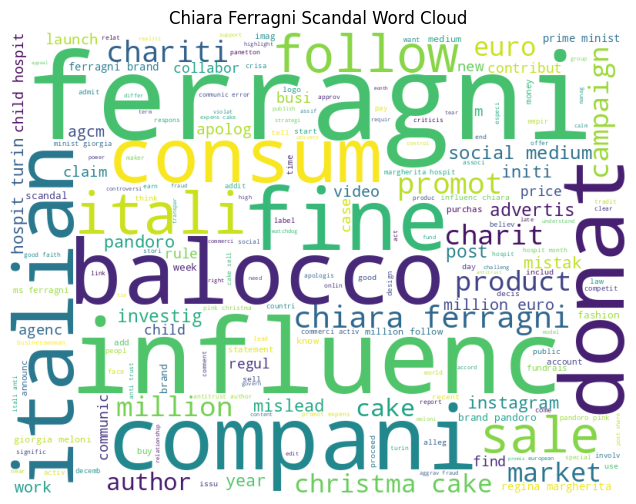

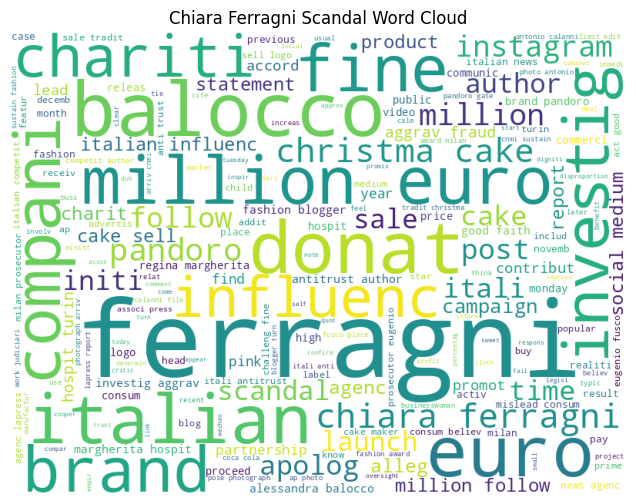

In [ ]:
wordcloud(world) #print a word cloud for all the articles in the data frames combined

In [ ]:
#simple sentiment analysis
sentiment_dict, average_sentiment_dict = sentiment(EU_scraped_data)#run the sentiment analysis for all the articles' dataframes
EU_scraped_data.update(sentiment_dict)
print("Average Sentiment per Article:")
for url, sentiment in average_sentiment_dict.items():
  print(f"URL: {url}")
  print(f"Average Sentiment Polarity: {sentiment}")

Average Sentiment per Article:
URL: https://www.bbc.co.uk/news/world-europe-67759633
Average Sentiment Polarity: Neutral
URL: https://www.telegraph.co.uk/world-news/2023/12/19/italy-influencer-chiara-ferragni-fined-christmas-cake-sale/
Average Sentiment Polarity: Neutral
URL: https://www.theguardian.com/world/2024/jan/13/chiara-ferragni-italy-influencers-charity-christmas-cake-scandal
Average Sentiment Polarity: Neutral
URL: https://www.independent.co.uk/life-style/chiara-ferragni-pandoro-charity-fined-b2467495.html
Average Sentiment Polarity: Neutral
URL: https://www.independent.co.uk/news/world/europe/chiara-ferragni-ap-italian-rome-italy-b2475218.html
Average Sentiment Polarity: Neutral
URL: https://www.independent.co.uk/news/world/europe/italian-ap-chiara-ferragni-cabinet-rome-b2485042.html
Average Sentiment Polarity: Neutral
URL: https://www.hellomagazine.com/hfm/culture/510008/chiara-ferragni-pandoro-panettone-scandal/
Average Sentiment Polarity: Neutral
URL: https://www.euronews

In [ ]:
#complex sentiment analysis
comp_sentiment_dict = comp_sentiment(EU_scraped_data)#run the sentiment analysis for all the articles' dataframes
EU_scraped_data.update(comp_sentiment_dict)

In [ ]:
#topic modeling
dictionary, lda_model = topic_modeling(world)

#Printing Identified Topics
print("Topics:")
for topic_id in range(lda_model.num_topics):
  print(f"Topic {topic_id+1}:")
  print(lda_model.show_topics(num_words=3))

In [ ]:
#realtionship recognition
article_dict_with_relationships = relationships(EU_scraped_data)

In [ ]:
# Text summarization
summarize_article(EU_scraped_data)

https://www.bbc.co.uk/news/world-europe-67759633
Italy's top influencer Chiara Ferragni has apologised for misleading consumers over purchases of a Christmas cake.
Appearing on the verge of tears, she said she would appeal against the AGCM antitrust authority's ruling and "disproportionate and unjust" fine.
The "Pandoro Pink Christmas", which was labelled as being designed by Ms Ferragni, was sold last year for more than €9, well over twice the price of the classic unbranded pandoro produced by the Balocco company.
The watchdog found last Friday that buyers of the Ferragni-branded pandoro cake
had been fooled into thinking that their purchases would contribute to the purchase of medical equipment for the hospital for the treatment of children with Osteosarcoma and Ewing's Sarcoma.
Ms Ferragni, 36, has promised to donate €1m to the Regina Margherita hospital.
https://www.telegraph.co.uk/world-news/2023/12/19/italy-influencer-chiara-ferragni-fined-christmas-cake-sale/
Ms Ferragni, 36, to

# Reddit Implementation

In [ ]:
# reddit comments
reddit_posts = {'https://www.reddit.com/r/italy/comments/18ix1x6/antitrust_maxi_multa_a_chiara_ferragni_e_balocco/',
               'https://www.reddit.com/r/Italia/comments/149ttsb/i_pandori_balocco_di_chiara_ferragni_comprarli/',
               'https://www.reddit.com/r/italy/comments/18z3dll/e_pure_coca_cola_se_ne_va_meritato_o_stanno/',
               'https://www.reddit.com/r/Italia/comments/18ixpku/chiara_ferragni_1_milione_di_euro_di_multa/',
               'https://www.reddit.com/r/Italia/comments/18m0jsg/chiara_ferragni_dopo_il_pandoro_le_uova_di_pasqua/'}

reddit_scraped_data = {}

for url in reddit_posts:
    data = scrape_reddit(url)
    reddit_scraped_data[url] = data

### Reddit NLP Application